# Tiny convolutional network with old but gold VGG architecture

In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 1

env: CUDA_VISIBLE_DEVICES=1


Import necessary tools, again.

In [15]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd

from nbtools.core import get_notebook_name

from batchflow import Pipeline, B, V, I, M, C, Notifier, plot
from batchflow.models.torch import TorchModel, VGGBlock

from loader import ImagesDataset
from plotter import plot_notifier_curve
from evaluator import MetricsEvaluator

Get notebook name and use it as an experiment name.

In [3]:
NAME = get_notebook_name()
NAME

'02_VGG'

Define seed for reproducibility.

In [4]:
SEED = 11
rng = np.random.default_rng(SEED)

Load data, encode labels, normalize images, resize them to same square shape.

Normalization stats are calculated over train subset to avoid data leak.

Split the data on train and test subsets with fixed seed.

In [21]:
DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.n_classes

dataset.split(shuffle=SEED)

train_uniques, train_counts = np.unique(dataset.labels[dataset.train.indices], return_counts=True)
train_shares = train_counts / train_counts.sum()

100%|█████████████████████████████████████████████| 9/9 [00:20<00:00,  2.24s/it]


Define a simple network  config. It's a tiny VGG architecture, each block has a `cna` layout (repeated `depth1` + `depth3` times, as original paper suggests), where `c` stand for convolution, `n` — for batch normalization and `a` — for default activation function (ReLU). Number of data channels is changed in the beginning of every block, and there are three of them in total. This chonky boy is finalized by global average pooling (`V`) plus dropout (`d`) and finally, a dense layer (`f`) aka fully connected.

As for optimization params, they are pretty much the same as in the logistic regression notebook. Even a bit more simple, since I decided to throw the decay out due to its zero effect across multiple re-runs.

In [6]:
MODEL_CONFIG = {
    # Model architecture
    'body': {
        'type': 'encoder',
        'output_type': 'tensor',
        'order': ['block', 'downsampling'],
        'num_stages': 3,
        'blocks': {
            'base_block': VGGBlock,
            'channels': [64, 128, 256],
            'depth3': 2,
            'depth1': [0, 0, 1],
        },
    },

    'head': {
        'layout': 'Vdf',
        'dropout_rate': 0.4,
        'classes': n_classes
    },

    'common/conv/bias' : False,

    # Model training details:
    'loss': 'ce',
    'optimizer': 'Adam',
    'output': {'predicted': ['proba', 'labels']},
}

Train and test pipelines are almost the same. The only notable difference is data preparation — it's not flattened now, but transposed so that channels dimension goes first to comply with how pytorch treats tensors. Convolutions go brrr!

In [7]:
def evaluate_metrics(iteration, frequency, template, model, metrics):
    if (iteration - 1) % frequency == 0:
        
        test_pipeline = test_template << dataset.test << {'model': model}
        test_pipeline.run(batch_size=dataset.test.size, n_epochs=1, drop_last=False)
        
        metrics_values = []
        for metric_name, metric_config in metrics.items():
            metric_value = test_pipeline.v('metrics').evaluate(metric_name, **metric_config)
            metrics_values.append([metric_value])

        return metrics_values
    return [[],[],[]]


train_template = (
    Pipeline()
    # prepare data
    .to_array(channels='first', dtype=np.float32)
    
    # initialize loss and metrics containers
    .init_variable(name='loss_history', default=[])
    .init_variable(name='accuracy', default=[])
    .init_variable(name='precision', default=[[np.nan] * n_classes])
    .init_variable(name='recall', default=[[np.nan] * n_classes])
    
    # initialize model to train
    .init_model(name='model', model_class=TorchModel, mode='dynamic', config=MODEL_CONFIG)
    
    # launch train itself
    .train_model(name='model', inputs=B('images'), targets=B('labels'),
                 outputs='loss', save_to=V('loss_history', mode='a'))
    
    # evaluate model
    .call(evaluate_metrics, iteration=I(), template=C('evaluate/template'), model=M('model'),
          frequency=C('evaluate/frequency'), metrics=C('evaluate/metrics'),
          save_to=[V('accuracy', mode='e'), V('precision', mode='e'), V('recall', mode='e')])
)

test_template = (
    Pipeline()
    # prepare data
    .to_array(channels='first', dtype=np.float32)

    # initialize prediction and metrics containers
    .init_variables('proba', 'predictions', 'metrics')
    
    # import trained model
    .import_model('model', C('model'))
    
    # make predictions
    .predict_model(name='model', inputs=B('images'),
                   outputs=['predicted_proba', 'predictions'],
                   save_to=[V('proba'), V('predictions')])
    
    # accumulate predictions in confusion matrix
    .gather_metrics('classification', targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', num_classes=n_classes,
                    axis=1, save_to=V('metrics', mode='update'))
)

TEST_FREQUENCY = 250

train_config = {
    'evaluate' : {
        'template': test_template,
        'frequency': TEST_FREQUENCY,
        'metrics': {
            'accuracy': {},
            'precision': {'multiclass': None},
            'recall': {'multiclass': None},
        }
    }
}

train_pipeline = train_template << dataset.train << train_config

Again, notifier config, that delievers us those pretty graphs. The reasoning behind `N_EPOCHS` value choice is exactly the same as in the previous model case — after 200 epochs evaluation metrics start decreasing.

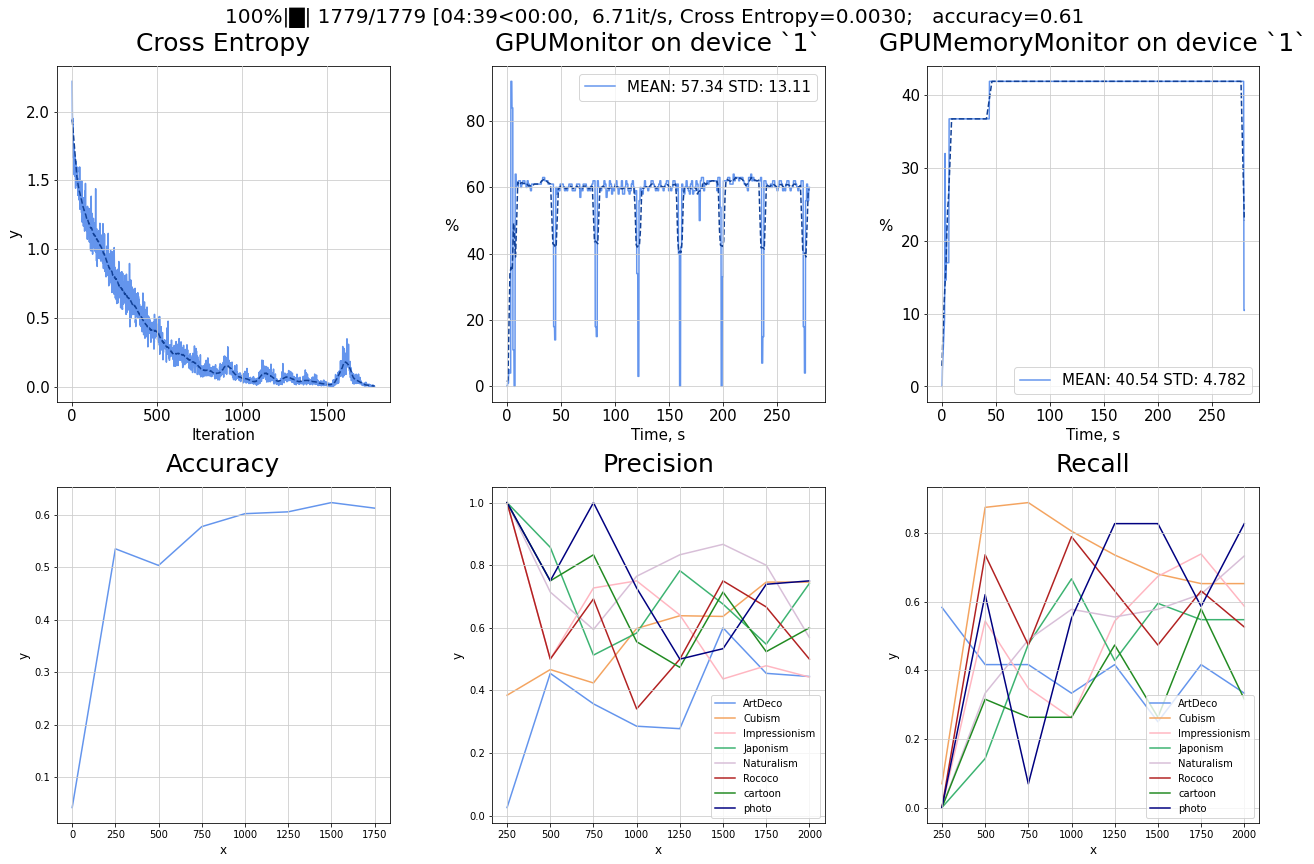

In [8]:
notifier = Notifier(**{
    'frequency': TEST_FREQUENCY,
    'graphs': [
        {
            'source': 'loss_history',
            'name': 'Cross Entropy',
        },
        'gpu',
        'gpu_memory',
        {
            'source': 'accuracy',
            'plot_function': plot_notifier_curve,
            'plot_config': {
                'title': 'Accuracy',
                'frequency': TEST_FREQUENCY
            }
        },
        {
            'source': train_pipeline.v('precision'),
            'plot_function': plot_notifier_curve,
            'plot_config': {
                'label': list(dataset.label_encoder.classes_),
                'legend_size': 10,
                'title': 'Precision',
                'frequency': TEST_FREQUENCY
            },
        },
        {
            'source': train_pipeline.v('recall'),
            'plot_function': plot_notifier_curve,
            'plot_config': {
                'label': list(dataset.label_encoder.classes_),
                'legend_size': 10,
                'title': 'Recall',
                'frequency': TEST_FREQUENCY
            },
        }
    ],
    'plot_config': {
        'ncols': 3, 'nrows': 2
    }
})

BATCH_SIZE = 128
N_EPOCHS = 200

_ = train_pipeline.run(batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, shuffle=True, notifier=notifier)

Ok, that model was training more that a minute, let's dump it on disk, it'll save us some time in the future.

In [43]:
MODEL_PATH = f'../models/{NAME}.torch'
model = train_pipeline.model
# model.save(MODEL_PATH)

Obtain predictions.

In [31]:
test_pipeline = test_template << dataset.test << {'model': model}
test_pipeline.run(batch_size=dataset.test.size, n_epochs=1, drop_last=False, bar='t')

Calculate metrics.

Wow, that's better! `ArtDeco` and `cartoon` classes are still suffer, but much less.

,shares,precision,recall
ArtDeco,4.7,75.0,50.0
Cubism,25.7,64.1,81.9
Impressionism,17.0,51.7,65.2
Japonism,14.1,75.9,52.4
Naturalism,15.2,83.8,68.9
Rococo,8.6,52.0,68.4
cartoon,4.9,63.6,36.8
photo,9.7,79.2,65.5


,accuracy,f1_score
altogether,65.8,64.5


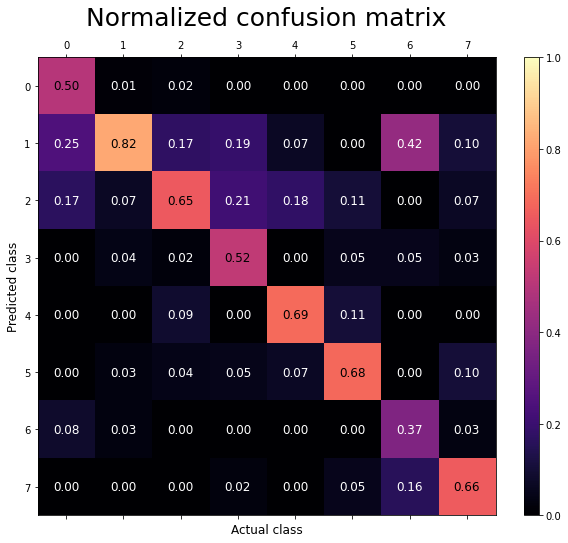

In [30]:
METRICS_PATH = f'../metrics/{NAME}.json'

evaluator = MetricsEvaluator(classes=dataset.classes, metrics=test_pipeline.v('metrics'), shares=train_shares)
metrics_dict = evaluator.evaluate_classification_metrics(show=True, savepath=METRICS_PATH)

Metrics saved for future comparison.